# Total Dissolved Solids (TDS) Analysis

A notebook for looking at TDS to see if any trends pop out regarding TDS/[Extraction Yield](https://en.wikipedia.org/wiki/Coffee_extraction#Definitions). Starting from the hypothesis that it is relatively insignificant, being more akin to ratio than an indicator of taste/quality.


## TDS Collection Workfloe

No filtering is based on analysis done by [Socratic Coffee](http://socraticcoffee.com/2015/07/measuring-total-dissolved-solids-a-refractometer-comparison-part-iii-espresso-filters/) plus there was the desire to avoid wasting tons of plastic for investigations into something that don't seem super consistent to begin with (~1.75% difference in socratic coffee test while filtering). For fine tuning a shot rank ordering would provide all that is neccessary and for QA it would depend on the acceptable shot to shot variablity. 

Measured using the [Atago Coffee refractometer](https://www.atago.net/product/?l=en&f=products-pal-top.php#CGD50756)

1. Pull the shot
1. Stir shot with spoon for ~5 seconds
1. Extract 1.5ml of liquid using coffee syringe and place in cup to cool
1. Consume
1. Rinse coffee syringe (lets not waste a ton of syringes here)
1. Use distilled water syringe to zero Atago
1. Use rinsed coffee syringe to move cooled coffee (no filtering)
1. Collect data
1. Repeat

In [1]:
import os
import math

from collections import defaultdict
from tempfile import NamedTemporaryFile

import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, kendalltau
from sklearn.metrics import r2_score

from optpresso import __file__ as optpresso_path
from optpresso.data.partition import find_test_paths

from IPython.core.display import display

In [2]:
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv"
plt.rcParams["figure.dpi"] = 150

In [3]:
# Download CSV, won't work on windozes
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
# Clean up the CSV file.
for char in [' ', '(', ')', "%", "/", "\\", '"']:
    df.columns = df.columns.str.strip().str.lower().str.replace(char, '')
df = df[df["grinder"].astype(bool)][df["grindersetting"].astype(bool)]
# Only look at data with TDS values and ratings
invalid_indices = df[df["tdsatagounfiltered"].isna() | df["arbitraryrating1-10"].isna()].index
df.drop(invalid_indices, inplace=True)
df = df.assign(extraction_yield = df.tdsatagounfiltered * df.output / df.coffeegrams)
df.drop(df[df.extraction_yield.isna()].index, inplace=True)
df.date = pd.to_datetime(df.date, infer_datetime_format=True, utc=True)
df.roastdate = pd.to_datetime(df.roastdate, infer_datetime_format=True, utc=True)
df = df.assign(days_off_roast = df.date - df.roastdate)

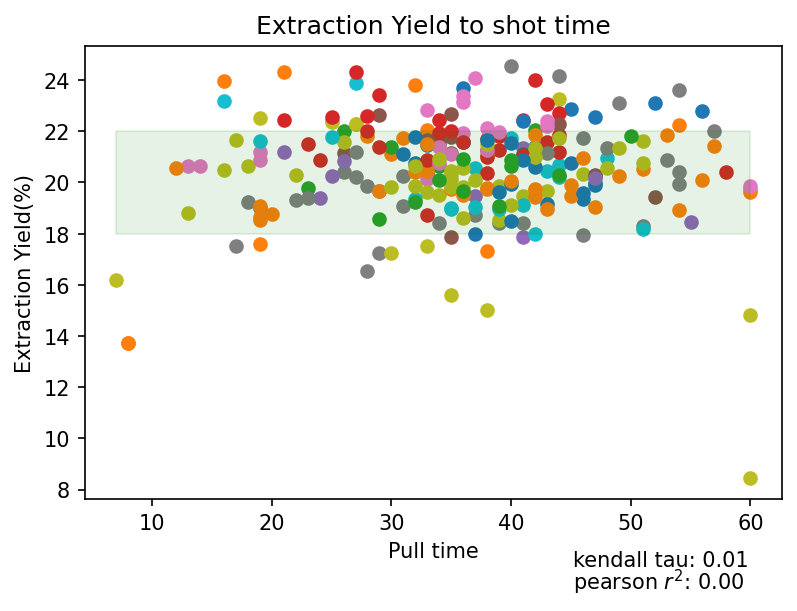

In [4]:
for name, subdf in df.groupby(["coffee", "grinder"]):
    plt.scatter(subdf.time, subdf.extraction_yield, label=": ".join(name))
ax = plt.gca()
ax.set_title("Extraction Yield to shot time")
ax.set_ylabel("Extraction Yield(%)")
ax.set_xlabel("Pull time")
# http://www.scaa.org/?d=brewing-standards&page=resources
plt.fill_between([df["time"].min(), df["time"].max()], 18, 22, color='g', alpha=.1, label="Speciality Standard")
# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
model_stats = {
    "kendall tau": kendalltau(df.time, df.extraction_yield)[0],
    "pearson $r^2$": pearsonr(df.time, df.extraction_yield)[0]**2,
}
for i, (name, stat) in enumerate(model_stats.items()):
    ax.annotate(
        f"{name}: {stat:.2f}",
        (0.7, -0.15 - 0.05 * i),
        xycoords="axes fraction"
    )
plt.show()

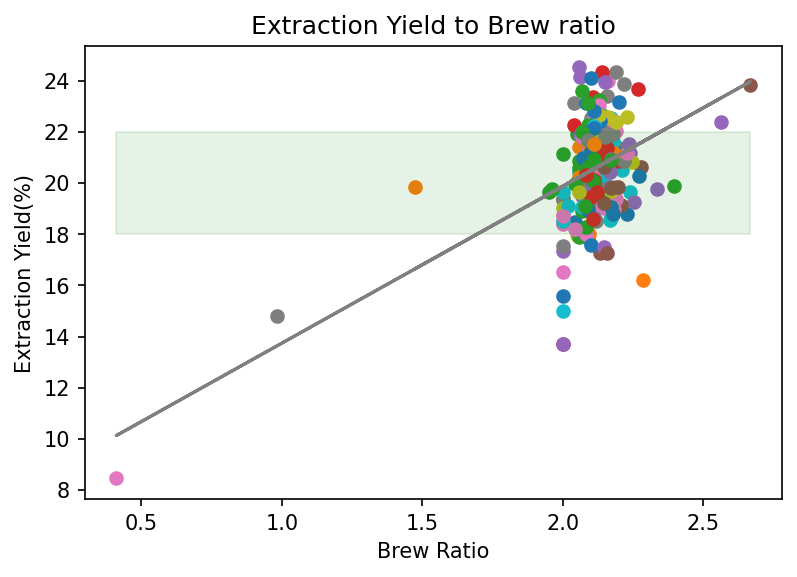

In [5]:
ratio_df = df[df.brewratio.notna()]
for name, subdf in ratio_df.groupby(["coffee", "grinder", "grindersetting"]):
    plt.scatter(subdf.brewratio, subdf.extraction_yield, label=": ".join(name))
ax = plt.gca()
ax.set_title("Extraction Yield to Brew ratio")
ax.set_ylabel("Extraction Yield(%)")
ax.set_xlabel("Brew Ratio")
# print(df[df.brewratio.notna()])
poly_fit = np.poly1d(np.polyfit(ratio_df.brewratio, ratio_df.extraction_yield, 1))

plt.plot(
    ratio_df.brewratio.unique(),
    poly_fit(ratio_df.brewratio.unique()),
    color="gray",
    linestyle="-",
    label="fit"
)
# http://www.scaa.org/?d=brewing-standards&page=resources
plt.fill_between([ratio_df["brewratio"].min(), ratio_df["brewratio"].max()], 18, 22, color='g', alpha=.1, label="Speciality Standard")
plt.show()

RATINGS ARE SUBJECTIVE


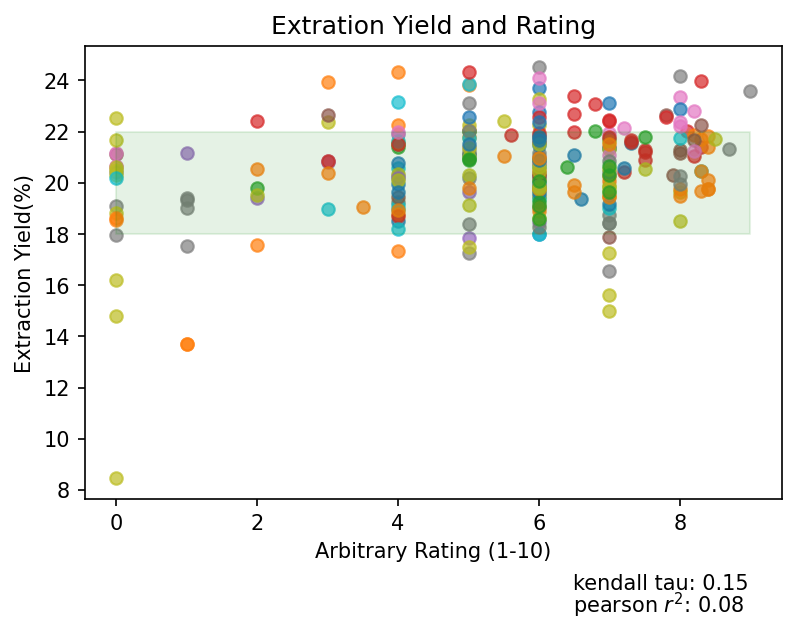

In [6]:
print("RATINGS ARE SUBJECTIVE")
for name, subdf in df.groupby(["coffee", "grinder"]):
    plt.scatter(subdf["arbitraryrating1-10"], subdf.extraction_yield, label=": ".join(name), alpha=.7)
ax = plt.gca()
ax.set_title("Extration Yield and Rating")
ax.set_ylabel("Extraction Yield(%)")
ax.set_xlabel("Arbitrary Rating (1-10)")
model_stats = {
    "kendall tau": kendalltau(df["arbitraryrating1-10"], df.extraction_yield)[0],
    "pearson $r^2$": pearsonr(df["arbitraryrating1-10"], df.extraction_yield)[0]**2,
}
for i, (name, stat) in enumerate(model_stats.items()):
    ax.annotate(
        f"{name}: {stat:.2f}",
        (0.7, -0.20 - 0.05 * i),
        xycoords="axes fraction"
    )
# http://www.scaa.org/?d=brewing-standards&page=resources
plt.fill_between([df["arbitraryrating1-10"].min(), df["arbitraryrating1-10"].max()], 18, 22, color='g', alpha=.1, label="Speciality Standard")

# plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

RATINGS ARE SUBJECTIVE


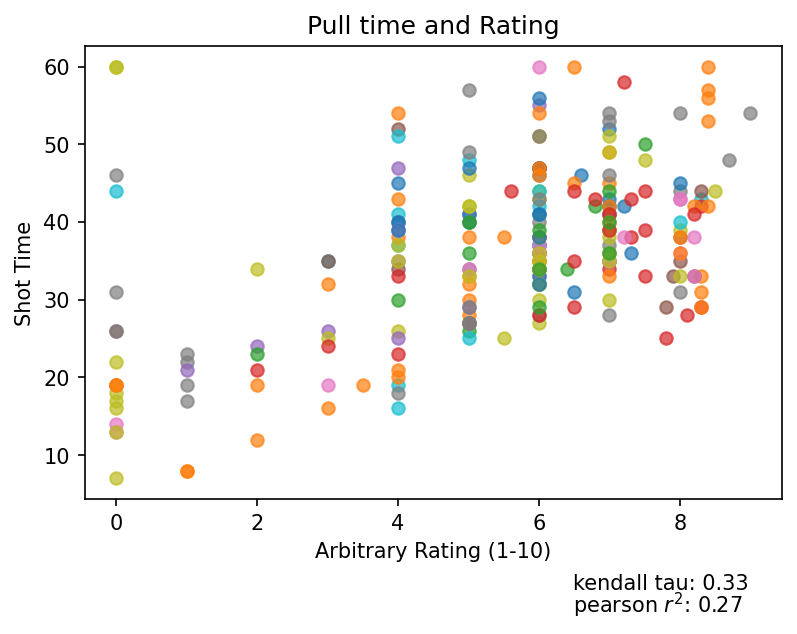

In [7]:
print("RATINGS ARE SUBJECTIVE")
for name, subdf in df.groupby(["coffee", "grinder"]):
    plt.scatter(subdf["arbitraryrating1-10"], subdf.time, label=": ".join(name), alpha=.7)
ax = plt.gca()
ax.set_title("Pull time and Rating")
ax.set_ylabel("Shot Time")
ax.set_xlabel("Arbitrary Rating (1-10)")
model_stats = {
    "kendall tau": kendalltau(df["arbitraryrating1-10"], df.time)[0],
    "pearson $r^2$": pearsonr(df["arbitraryrating1-10"], df.time)[0]**2,
}
for i, (name, stat) in enumerate(model_stats.items()):
    ax.annotate(
        f"{name}: {stat:.2f}",
        (0.7, -0.20 - 0.05 * i),
        xycoords="axes fraction"
    )

plt.show()

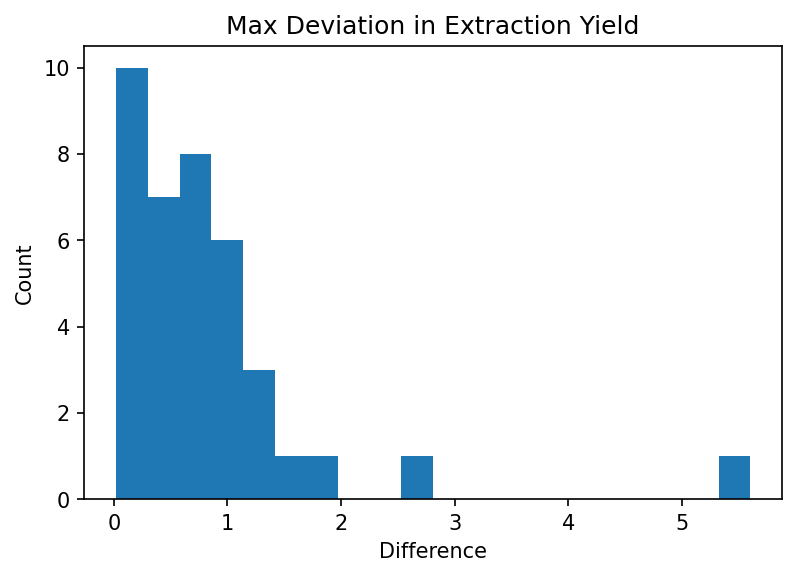

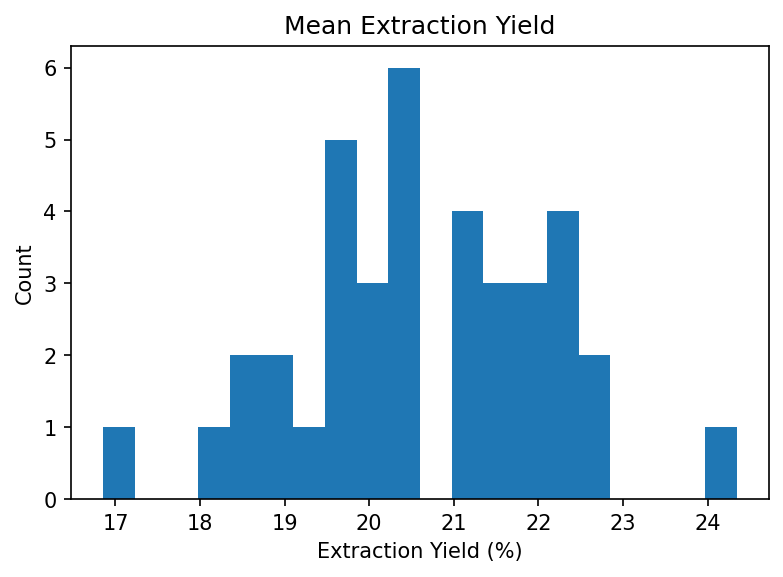

In [8]:
deviation = []
mean_vals = []
for name, subdf in df.groupby(["roastdate", "grindersetting", "coffee", "grinder"]):
    if len(subdf) < 2: # Only care about cases where we have at least 2 values
        continue
    deviation.append(subdf.extraction_yield.mad())
    mean_vals.append(subdf.extraction_yield.mean())
plt.hist(deviation, bins=20)
plt.title("Max Deviation in Extraction Yield")
plt.xlabel("Difference")
plt.ylabel("Count")
plt.show()


plt.hist(mean_vals, bins=20)
plt.title("Mean Extraction Yield")
plt.xlabel("Extraction Yield (%)")
plt.ylabel("Count")
plt.show()

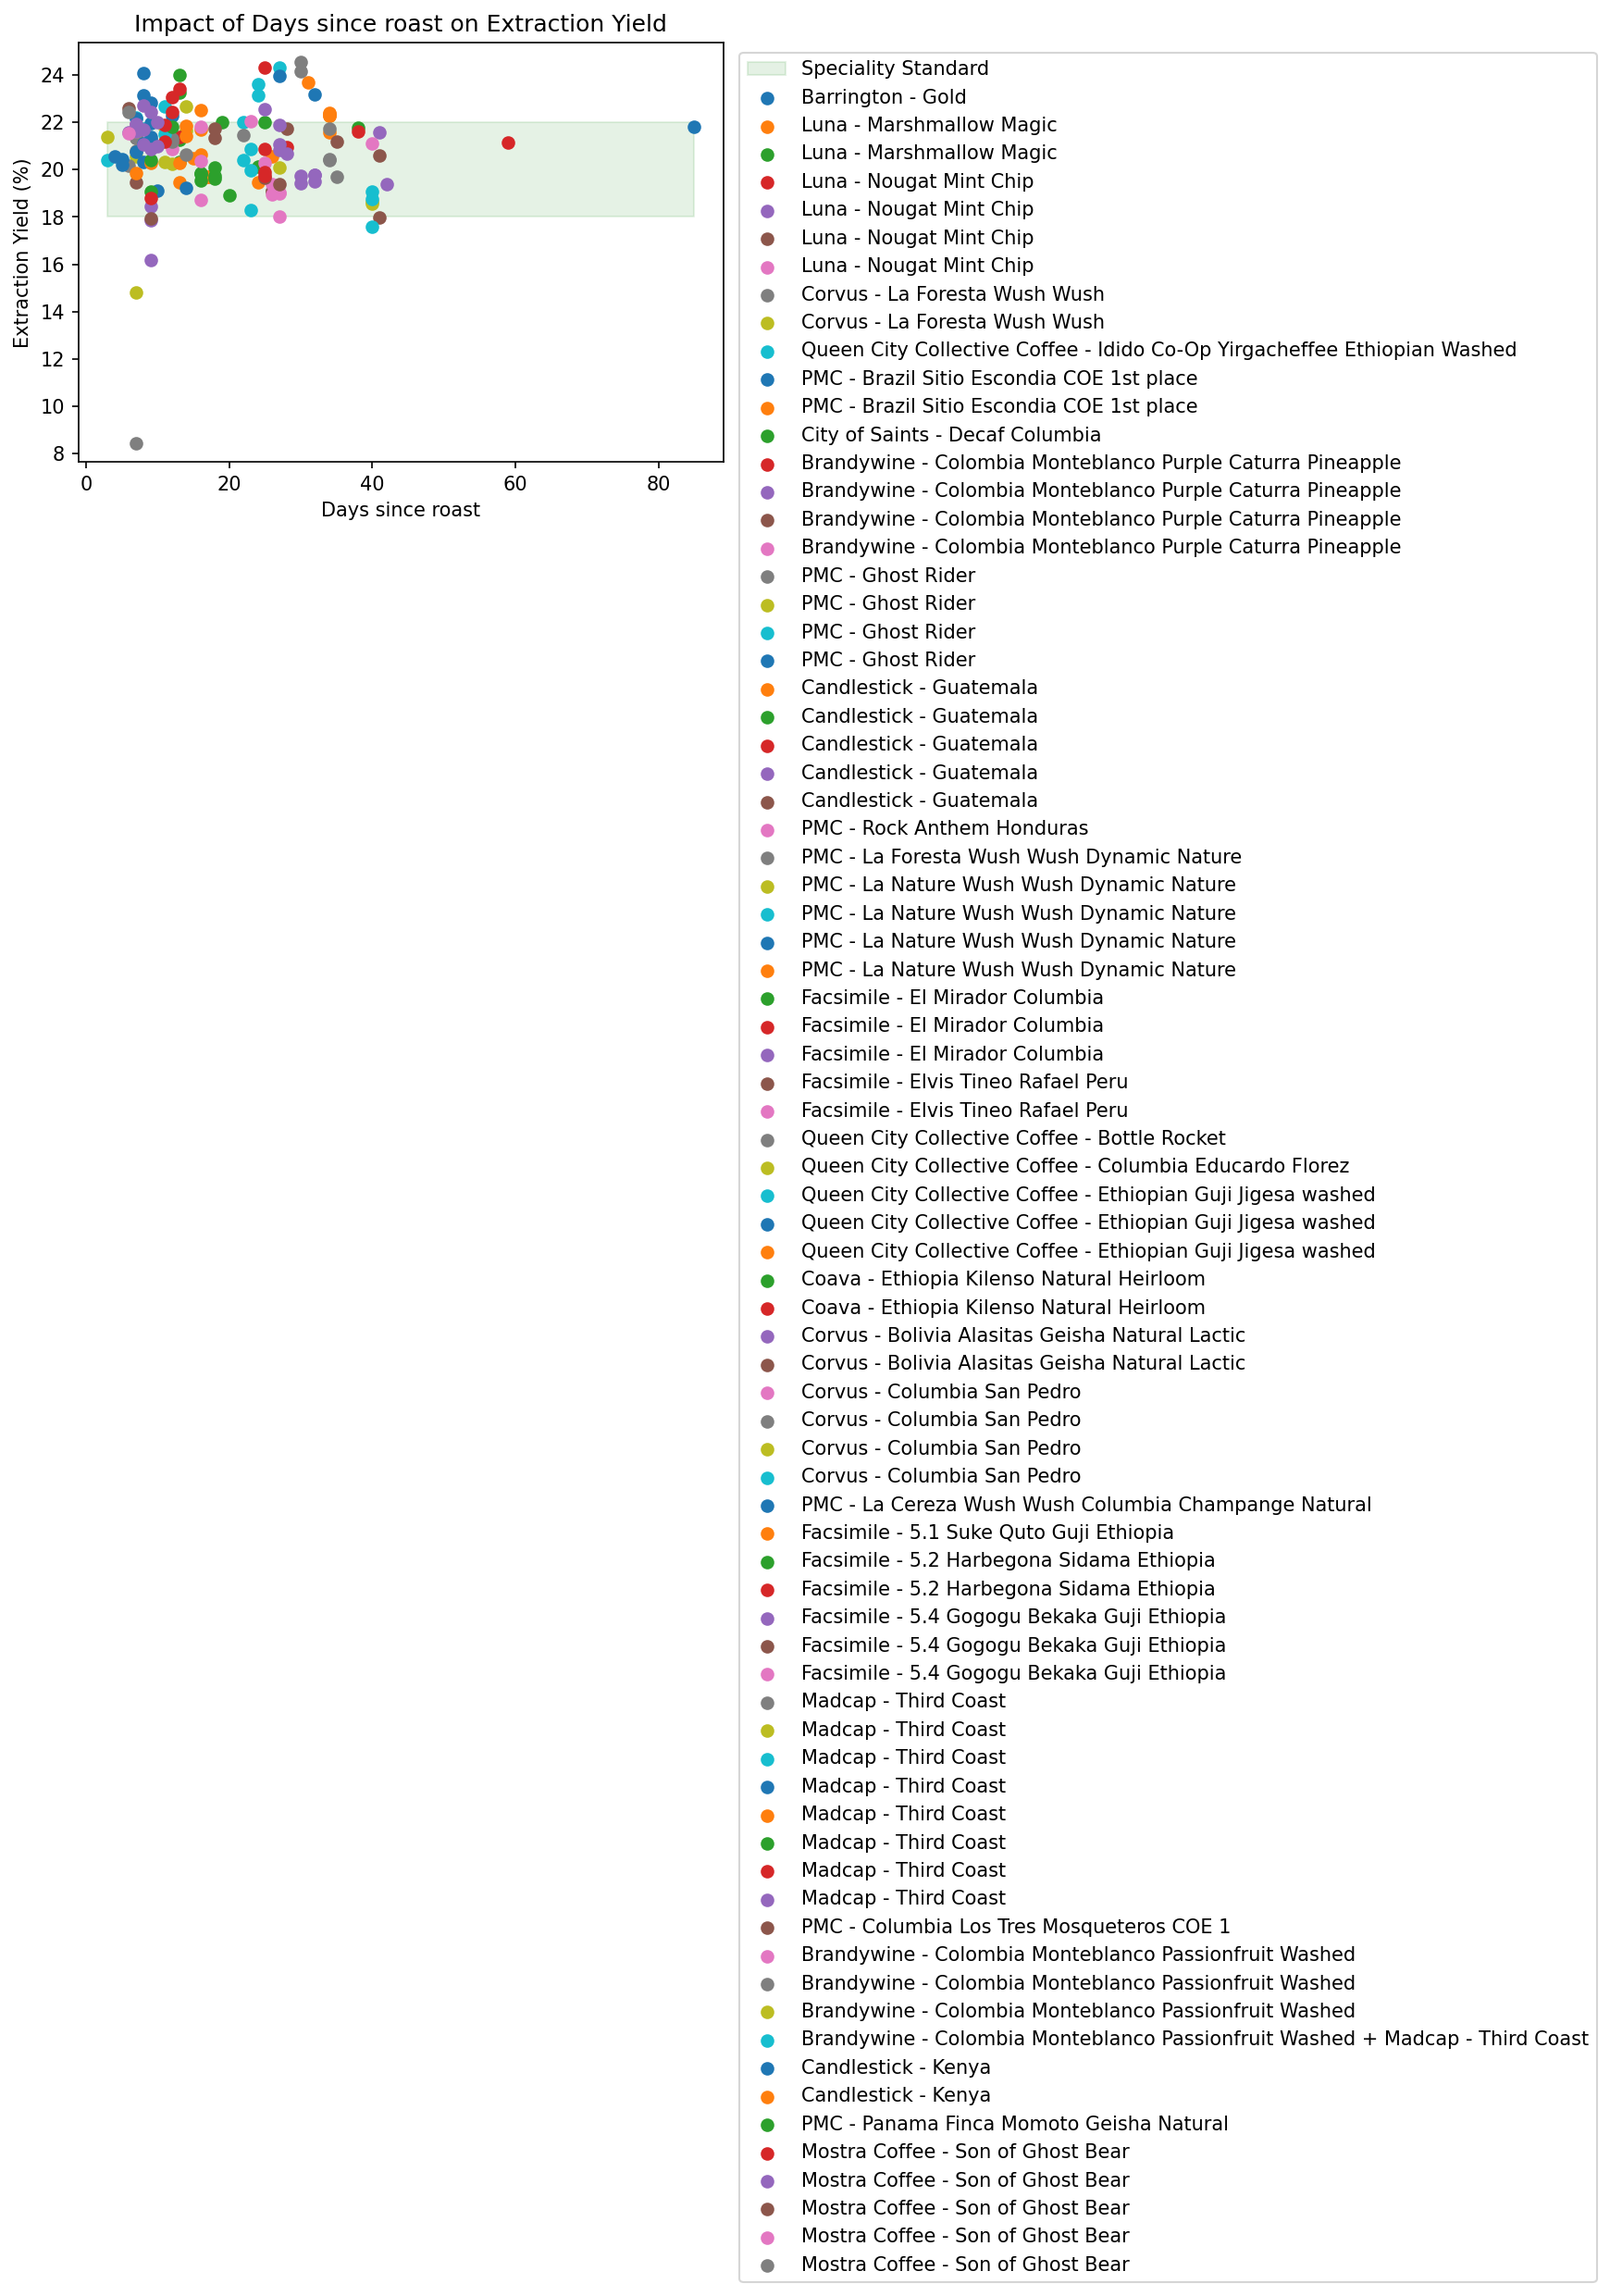

In [9]:
offroast_df = df[df["days_off_roast"].notna()]
plt.fill_between(
    [offroast_df["days_off_roast"].astype("timedelta64[D]").min(), offroast_df["days_off_roast"].astype("timedelta64[D]").max()],
    18,
    22,
    color='g',
    alpha=.1,
    label="Speciality Standard"
)
pearson_rs = []
for name, subdf in offroast_df.groupby(["roastdate", "coffee", "grindersetting"]):
    plt.scatter(subdf.days_off_roast.astype("timedelta64[D]"), subdf.extraction_yield, label=subdf.coffee.unique()[0])
plt.title("Impact of Days since roast on Extraction Yield")
plt.xlabel("Days since roast")
plt.ylabel("Extraction Yield (%)")
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

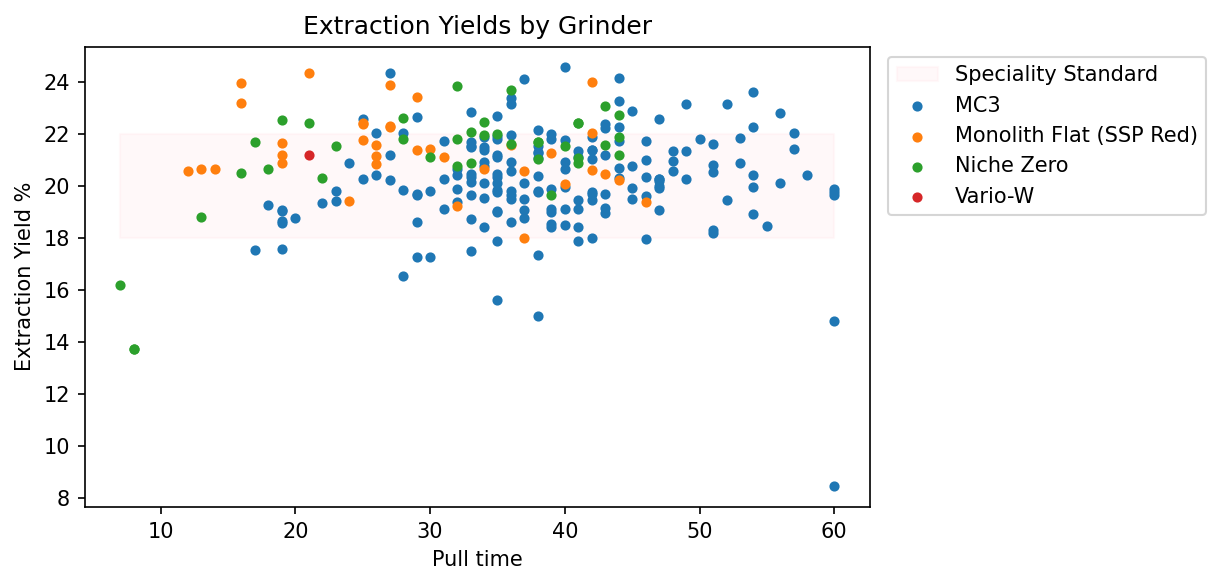

In [10]:
df["grindercount"] = df.groupby("grinder")["grinder"].transform("count")
df.sort_values("grindercount", ascending=False, inplace=True)
grinders = df.grinder.unique()
num_grinders = len(grinders)
plt.fill_between(
    [df.time.min(), df.time.max()],
    18,
    22,
    color='pink',
    alpha=.1,
    label="Speciality Standard"
)
for i, grinder in enumerate(sorted(grinders)):
    subdf = df[df["grinder"] == grinder]
    plt.scatter(subdf.time, subdf.extraction_yield, s=15, label=grinder)
plt.xlabel("Pull time")
plt.ylabel("Extraction Yield %")
plt.title("Extraction Yields by Grinder")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

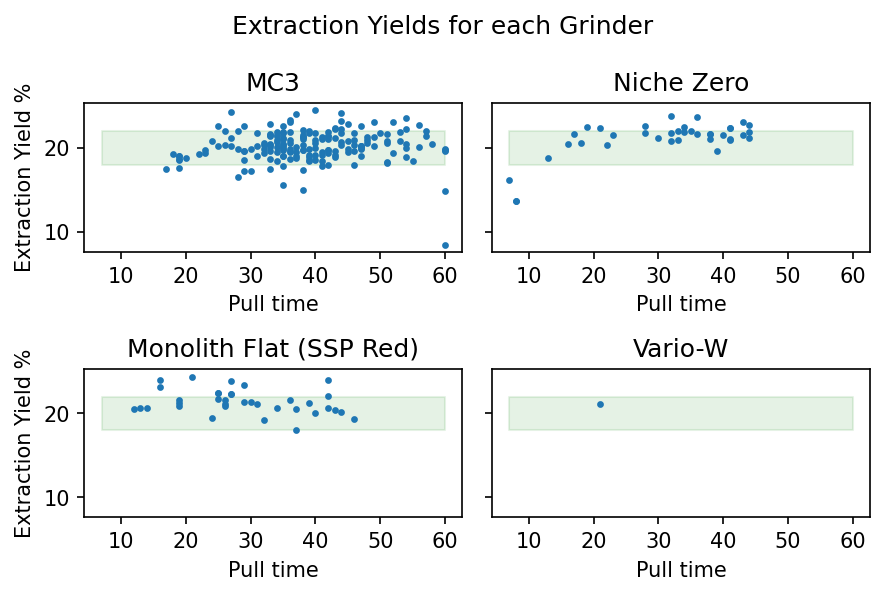

In [11]:
df["grindercount"] = df.groupby("grinder")["grinder"].transform("count")
df.sort_values("grindercount", ascending=False, inplace=True)
grinders = df.grinder.unique()
num_grinders = len(grinders)
rows = int(np.ceil(num_grinders / 2))
fig, axs = plt.subplots(rows, int(np.ceil(num_grinders / rows)), sharey=True)
axs = axs.reshape(-1)
for i, grinder in enumerate(grinders):
    subdf = df[df["grinder"] == grinder]
    axs[i].fill_between(
        [df.time.min(), df.time.max()],
        18,
        22,
        color='g',
        alpha=.1,
        label="Speciality Standard"
    )
    axs[i].scatter(subdf.time, subdf.extraction_yield, s=5)
    axs[i].set_title(grinder)
    axs[i].set_xlabel("Pull time")
    if i % 2 == 0:
        axs[i].set_ylabel("Extraction Yield %")
# Blow away any empty axes
for i in range(num_grinders, axs.size):
    axs[i].set_axis_off()
fig.suptitle("Extraction Yields for each Grinder")
fig.tight_layout()
plt.show()